In [36]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
#Import the Dataset from txt files
colnames = ["time/s\t", "current/A\t", "potential/V"]

path = r'C:\Users\Sebastian\Documents\RWTH\IDS\Aufgaben\py_challenges\01_challenge\01-data\80CO2_20CO' # use your path
all_files = glob.glob(path + "/*.txt")

li = []

#Loop which takes all files in the path and imports them
for filename in all_files:
    naming = filename.split() #take the filename and split all parts it into a list
    naming_temp = naming[1] #Temperature is the second part in the list, since lists start at 0 it is 1
    naming_co = naming[4]
    naming_co2 = naming[2]
    df = pd.read_csv(filename, index_col=None,sep='\s+', names = colnames, skiprows = 1, dtype = np.float64)
    df["T/°C"] = naming_temp
    df["CO2/%"] = naming_co2
    df["CO/%"] = naming_co
    li.append(df)

df8020 = pd.concat(li, axis=0, ignore_index=True)

path = r'C:\Users\Sebastian\Documents\RWTH\IDS\Aufgaben\py_challenges\01_challenge\01-data\50CO2_50CO' # use your path
all_files = glob.glob(path + "/*.txt")

li = []

for filename in all_files:
    naming = filename.split()
    naming_temp = naming[1]
    naming_co = naming[4]
    naming_co2 = naming[2]
    df = pd.read_csv(filename, index_col=None,sep='\s+', names = colnames, skiprows = 1, dtype = np.float64) 
    df["T/°C"] = naming_temp
    df["CO2/%"] = naming_co2
    df["CO/%"] = naming_co
    li.append(df)

df5050 = pd.concat(li, axis=0, ignore_index=True)

In [38]:
#compute the current density for each of the dataframe
df5050["current_density"] = df5050["current/A\t"] / 0.785
df8020["current_density"] = df8020["current/A\t"] / 0.785

#Build a combined dataframe by appending df8020 to df5050
combined_df = df5050.append(df8020)

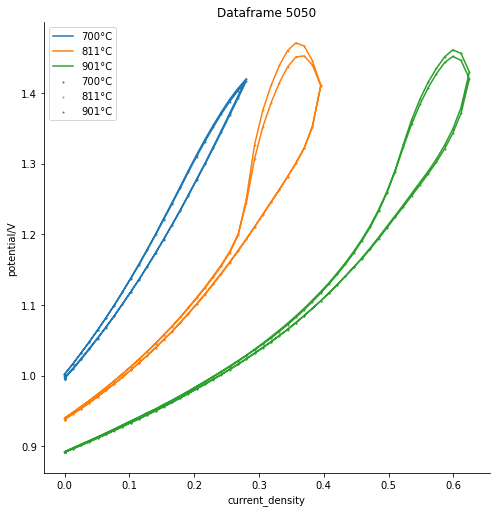

In [48]:
#Plot for Df5050 as specified in the readme
g = sns.FacetGrid(df5050, hue="T/°C", height=7)
g.map(plt.scatter, "current_density", "potential/V", s=1)
g.map(plt.plot, "current_density", "potential/V")
plt.title("Dataframe 5050")
plt.legend()

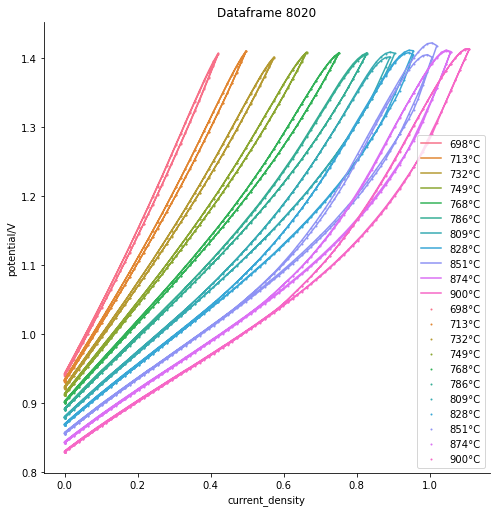

In [47]:
#Plot for Df8020 as specified in the readme
g = sns.FacetGrid(df8020, hue="T/°C", height=7)
g.map(plt.scatter, "current_density", "potential/V", s =1)
g.map(plt.plot, "current_density", "potential/V")
plt.title("Dataframe 8020")
plt.legend()

In [41]:
#start to build the final dataframe as specified in the readme
final_df = pd.DataFrame()
final_df["T/°C"] = combined_df['T/°C'].unique() #copy the temperatures from combined_df
arr = [] #empty arrays to fill with the calculated/extracted values to later append to the final_df
arr2 = []

#in the following we take the temperature to iterate over since those are unique values
for temp in combined_df['T/°C'].unique():
    val = int(combined_df[combined_df['T/°C'] == temp]["CO2/%"].unique()[0])
    val2 = int(combined_df[combined_df['T/°C'] == temp]["CO/%"].unique()[0])
    arr.append(val)
    arr2.append(val2)
    
final_df["CO2/%"] = arr
final_df["CO/%"] = arr2

In [42]:
#Determine the Open Circuit Voltage (OCV): this is the potential, where the current is 0
arr = []
arr1 = []
arr2 = []
for temp in combined_df['T/°C'].unique():
    pot = combined_df[(combined_df["current_density"] == min(combined_df[combined_df['T/°C'] == temp].loc[:,'current_density'], key=abs)) 
                      & (combined_df["T/°C"]== temp )]['potential/V']
    ars = combined_df[(combined_df["current_density"] == min(combined_df[combined_df['T/°C'] == temp].loc[:,'current_density'], key=lambda x:abs(x-0.1))) 
                      & (combined_df["T/°C"]== temp )]['potential/V']
    cdy = combined_df[(combined_df["potential/V"] == min(combined_df[combined_df['T/°C'] == temp].loc[:,'potential/V'], key=lambda x:abs(x-1.4))) 
                      & (combined_df["T/°C"]== temp )]['current_density']
    arr.append(np.mean(pot))
    arr1.append(np.mean(ars))
    arr2.append(np.mean(cdy))
    
final_df["OCV/V"] = arr
final_df["ASR/ohm cm^2"] = arr1
final_df["J_1.4V/A cm^2"] = arr2

In [43]:
#export final_df to csv as final_df.csv
final_df.to_csv(r'final_df.csv', index = False, header=True)